In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.exceptions import DataConversionWarning
import warnings
import pandas as pd
from pywt import wavedec
from pywt import waverec
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import VotingClassifier
from keras.utils import to_categorical
import pywt
import scipy
import biosppy
#from keras.utils import plot_model #plot_model(model, to_file='model.png')
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SVMSMOTE
import pylab as pl
from sklearn.utils import resample
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Input, Add, Flatten, Concatenate, MaxPool1D, Conv1D, Bidirectional, LSTM, Reshape

In [8]:
eeg1 = pd.read_csv("train_eeg1.csv").iloc[:, 1:]
eeg2 = pd.read_csv("train_eeg2.csv").iloc[:, 1:]
emg  = pd.read_csv("train_emg.csv").iloc[:, 1:]
df_y = pd.read_csv("train_labels.csv").iloc[:, 1:]

eeg1_t = pd.read_csv("test_eeg1.csv").iloc[:, 1:]
eeg2_t = pd.read_csv("test_eeg2.csv").iloc[:, 1:]
emg_t = pd.read_csv("test_emg.csv").iloc[:, 1:]

#### Delta  (0.25-5  Hz),  Theta  (5-9  Hz),  Alpha  (9-12  Hz),  Beta  (12-20  Hz),  Gamma  (20-50  Hz)
In order for biosppy to work, each channel has to be a column 

In [9]:
eeg1 = eeg1.values
eeg2 = eeg2.values
emg = emg.values
y = df_y.values

eeg1_t = eeg1_t.values
eeg2_t = eeg2_t.values
emg_t = emg_t.values


In [10]:


print(eeg1.shape)
def transform_input_shape(eeg1, eeg2):
    eeg1_row = eeg1.flatten()
    eeg2_row = eeg2.flatten()
    matr = np.array([eeg1_row, eeg2_row])
    print(matr.shape)
    res= matr.T
    return res
channel_columns = transform_input_shape(eeg1, eeg2)
channel_columns_t = transform_input_shape(eeg1_t, eeg2_t)

(64800, 512)
(2, 33177600)
(2, 22118400)


In [11]:
print(channel_columns.shape)
data_sample = channel_columns[0:512, :]  # this is the first 4-second sample


(33177600, 2)


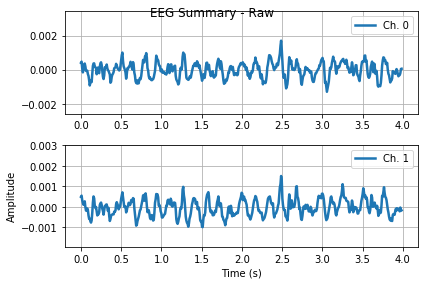

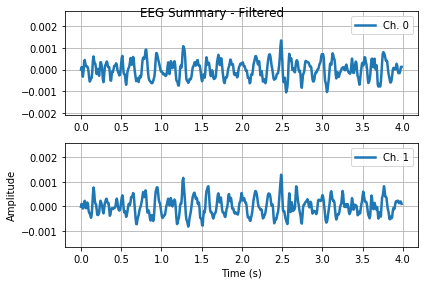

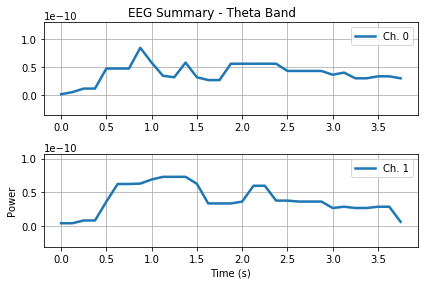

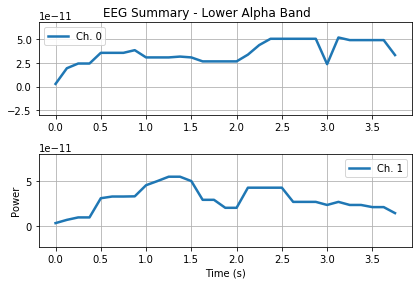

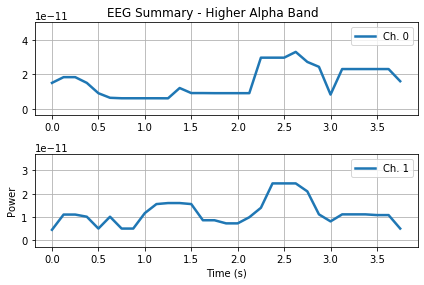

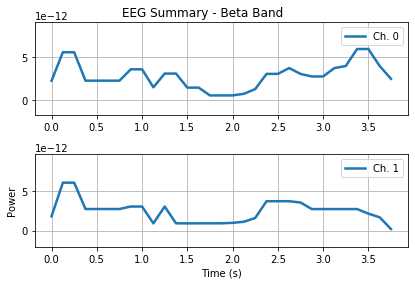

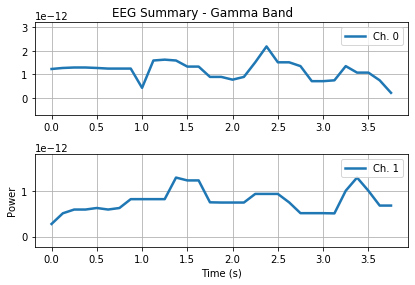

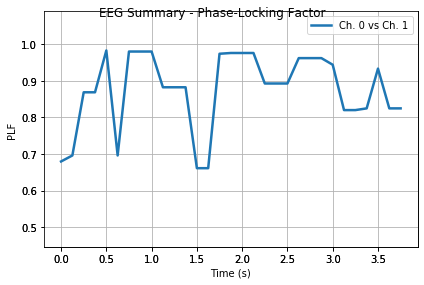

In [12]:
bsig = biosppy.signals.eeg.eeg(signal=data_sample, sampling_rate=128, show=True)

In [ ]:
print(eeg1[0:10, :])

In [ ]:
# since the values are really I will have to scale them later

In [ ]:
alpha_low = bsig[4]
print(alpha_low.shape)
print(alpha_low)

In [ ]:
alpha_high = bsig[5]
print(alpha_high.shape)
print(alpha_high)

In [ ]:
beta = bsig[6]
print(beta.shape)
print(beta)

In [ ]:
gamma = bsig[7]
print(gamma.shape)
print(gamma)

In [ ]:
## the idea now is to get all these freq ranges and put them in a feature matrix
def get_power_freqs(channel_cols):
    new_len = len(channel_cols)//512
    feat_matr = np.array([[0.0]*310]*new_len)    # 310 = 155 * (2 channels) 
    for i in range(new_len):
        begidx = i*512
        endidx = begidx+512
        sub_matr = channel_cols[begidx: endidx]
        feats = biosppy.signals.eeg.eeg(signal=sub_matr, sampling_rate=128, show=False)
        theta = (feats[3]).flatten('F')
        alpha_low = (feats[4]).flatten('F')
        alpha_high = (feats[5]).flatten('F')
        beta = (feats[6]).flatten('F')
        gamma= (feats[7]).flatten('F')
        #this_len = len(theta) + len(alpha_low) + len(alpha_high)+ len(beta)+ len(gamma)
        #print("the len is "+ str(this_len))
        feat_matr[i] = np.concatenate((theta, alpha_low, alpha_high, beta, gamma))
    return feat_matr

In [ ]:
power_feats = get_power_freqs(channel_columns)

In [ ]:
print(power_feats.shape)

In [ ]:
## Next feature is to compute the fast fourier tranform, then log scale it

In [ ]:
def get_fft(row):
    res = np.abs(np.fft.rfft(row))
    #print(res)
    return res  # since the negative frequency terms (i.e. the conjugates) are redundant

print(eeg1.shape)
eeg1_fft = np.apply_along_axis(get_fft, axis = 1, arr = eeg1)

In [ ]:
eeg2_fft = np.apply_along_axis(get_fft, axis = 1, arr = eeg2)

In [ ]:
print(eeg1_fft.shape)
print(eeg2_fft.shape)

In [ ]:
## log scale the power feature

get_min = 9000000
def log_scale(row):
    #global get_min
    #minr = np.min(row)
    #print(row)
    #get_min = min(minr, get_min)
    return np.log(row)  # try with and without it
print(get_min)
log_power_feats = np.apply_along_axis(log_scale, axis = 1, arr = power_feats)

In [126]:
#print(power_feats[200])

In [127]:
# get the average emg power, standardize everything, and apply PCA
def get_emg_power(emg_sig):
    avg_pow = emg_sig**2 #np.mean(emg_sig**2)  # try with and without using mean
    return avg_pow

emg_pow = np.apply_along_axis(get_emg_power, axis = 1, arr = emg)

In [128]:
theta_train = log_power_feats[:, 0:62]
alpha_train =log_power_feats[:, 62:(62+62+62)]   # slightly longer since it includes alpha low and alpha high 
beta_train = log_power_feats[:, 186:(186+62)]
gamma_train = log_power_feats[:, 248:(248+62)]

In [129]:
scaler_theta = StandardScaler()
scaler_alpha = StandardScaler()
scaler_beta = StandardScaler()
scaler_gamma = StandardScaler()
scaler_emg = StandardScaler()

In [130]:
scaler_theta.fit(theta_train)
scaler_alpha.fit(alpha_train)
scaler_beta.fit(beta_train)
scaler_gamma.fit(gamma_train)
scaler_emg.fit(emg_pow)

StandardScaler()

In [131]:
theta_scaled = scaler_theta.transform(theta_train)
alpha_scaled = scaler_alpha.transform(alpha_train)
beta_scaled = scaler_beta.transform(beta_train)
gamma_scaled = scaler_gamma.transform(gamma_train)
emg_scaled = scaler_emg.transform(emg_pow)

Apply same transofmration on test data

In [132]:
power_feats_t = get_power_freqs(channel_columns_t)
print(power_feats_t.shape)

(43200, 310)


In [133]:
log_power_feats_t = np.apply_along_axis(log_scale, axis = 1, arr = power_feats_t)
emg_pow_t = np.apply_along_axis(get_emg_power, axis = 1, arr = emg_t)

In [134]:
theta_test = log_power_feats_t[:, 0:62]
alpha_test =log_power_feats_t[:, 62:(62+62+62)]   # slightly longer since it includes alpha low and alpha high 
beta_test = log_power_feats_t[:, 186:(186+62)]
gamma_test = log_power_feats_t[:, 248:(248+62)]

theta_scaled_t = scaler_theta.transform(theta_test)
alpha_scaled_t = scaler_alpha.transform(alpha_test)
beta_scaled_t = scaler_beta.transform(beta_test)
gamma_scaled_t = scaler_gamma.transform(gamma_test)
emg_scaled_t = scaler_emg.transform(emg_pow_t)

In [ ]:
X_train = np.hstack((theta_scaled, alpha_scaled, beta_scaled, gamma_scaled, emg_scaled))
search_model_params = GridSearchCV(
    SVC(kernel = 'rbf'),{
    'C': [0.8, 0.85, 0.9, 1],
    'decision_function_shape' : ['ovo', 'ovr']
    }, cv=5,  n_jobs = -1, return_train_score = False
)
y = df_y.values - 1
search_model_params.fit(X_train, y)

X_test = np.hstack((theta_scaled_t, alpha_scaled_t, beta_scaled_t, gamma_scaled_t, emg_scaled_t))
def saveResults(best_param, best_score):
    f = open("bsmote_best_params_and_score.txt", "a")
    f.write(str(best_param))
    f.write("\n score: ")
    f.write(str(best_score))
    f.close()
    
saveResults(search_model_params.best_params_, search_model_params.best_score_)
predictions = search_model_params.prediction(X_test)

In [ ]:
## predict
dfPredictions = pd.DataFrame(predictions)
dfPredictions.index.name = "id"
dfPredictions.to_csv("task4SVM_V1.csv", header = ['y'], index=True)